<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/3_plot_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition

## Install and import dependencies


In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
numpy==1.21.6
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2

Writing requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 5.8 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1


In [3]:
import os
import time
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn
from skimage import io
from torchvision import transforms as torch_transforms
from torchvision import models
import pylab as plt
from skimage.segmentation import mark_boundaries

## Specify path, random seed, and band names

In [4]:
# path = 'agrifield_data/'
path = 'gdrive/MyDrive/agrifield_data/'

In [5]:
# drive.flush_and_unmount()

In [6]:
if 'gdrive' in path:
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 
              'B08','B8A', 'B09', 'B11', 'B12']

## Extract labels

In [8]:
data_dir = path + 'data'
train_label_collection = 'ref_agrifieldnet_competition_v1_labels_train'

In [9]:
f = os.listdir(os.path.join(data_dir, train_label_collection))[0]
with open(os.path.join(data_dir, train_label_collection, f, 'stac.json')) as ll:
    label_json = json.load(ll)

In [10]:
crop_dict = {asset.get('values')[0]:asset.get('summary') 
  for asset in label_json['assets']['raster_labels']['file:values']}
crop_dict

{1: 'Wheat',
 2: 'Mustard',
 3: 'Lentil',
 4: 'No Crop',
 6: 'Sugarcane',
 8: 'Garlic',
 15: 'Potato',
 5: 'Green pea',
 16: 'Bersem',
 14: 'Coriander',
 13: 'Gram',
 9: 'Maize',
 36: 'Rice'}

## List models

In [11]:
model_dir = os.path.join(path, 'models')
models = os.listdir(model_dir)
models.sort()
models

['1666567767_Sun Oct 23 23:29:27 2022_transformer',
 '1666567834_Sun Oct 23 23:30:34 2022_transformer',
 '1666568678_Sun Oct 23 23:44:38 2022_transformer',
 '1666568845_Sun Oct 23 23:47:25 2022_transformer',
 '1666573361_Mon Oct 24 01:02:41 2022_transformer',
 '1666575335_Mon Oct 24 01:35:35 2022_transformer',
 '1666576107_Mon Oct 24 01:48:27 2022_transformer',
 '1666576855_Mon Oct 24 02:00:55 2022_transformer',
 '1666577531_Mon Oct 24 02:12:11 2022_transformer',
 '1666578268_Mon Oct 24 02:24:28 2022_transformer',
 '1666578310_Mon Oct 24 02:25:10 2022_transformer',
 '1666582201_Mon Oct 24 03:30:01 2022_transformer',
 '1666582225_Mon Oct 24 03:30:25 2022_transformer',
 '1666582342_Mon Oct 24 03:32:22 2022_transformer',
 '1666582601_Mon Oct 24 03:36:41 2022_transformer',
 '1667078518_Sat Oct 29 21:21:58 2022_transformer',
 '1667078624_Sat Oct 29 21:23:44 2022_transformer',
 '1667078682_Sat Oct 29 21:24:42 2022_pretraining',
 '1667078830_Sat Oct 29 21:27:10 2022_pretraining',
 '1667078907

In [31]:
model_name = '1667150366_Sun Oct 30 17:19:26 2022_pretraining'
os.listdir(os.path.join(model_dir, model_name))

['best_model.pth', 'last_model.pth']

## Specify model and loaders

In [13]:
df = pd.read_csv(path + 'df_train.csv')

In [14]:
if not os.path.exists('data_cropped'):
  shutil.copytree(path + 'data_cropped', 'data_cropped')

In [15]:
df['data_path'] = df['data_path'].apply(lambda x: x.replace(path, ''))

In [16]:
class AgriDataset(torch.utils.data.Dataset):

  def __init__(self, df):
    self.df = df

  def __getitem__(self, index):
    x = io.imread(self.df['data_path'][index])
    x = torch.tensor(x, dtype=torch.float64)
    
    label = torch.tensor(self.df.iloc[index]['crop_ind'], dtype=torch.int64)
    field_id = torch.tensor(self.df.iloc[index]['field_id'], dtype=torch.int64)

    imgs = x[:-1]
    mask = x[-1]
    return imgs.float(), mask.float(), label, field_id
    

  def __len__(self):
    return len(self.df)

In [17]:
dl = torch.utils.data.DataLoader(
    AgriDataset(df), 
    shuffle=False, batch_size=16, num_workers=2,
    )

In [18]:
imgs, masks, labels, _ = next(iter(dl))

In [19]:
import math

class PositionEmbeddingSine(nn.Module):
    """
    Adapted from https://github.com/facebookresearch/detr/blob/main/models/position_encoding.py
    """

    def __init__(self, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, x):
        not_mask = torch.ones((x.shape[0],) + x.shape[-2:])
        y_embed = not_mask.cumsum(1, dtype=torch.float32).to(x.device)
        x_embed = not_mask.cumsum(2, dtype=torch.float32).to(x.device)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = self.temperature ** (2 * torch.div(dim_t, 2, rounding_mode='trunc') / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos

In [20]:
class Transformer(nn.Module):

    def __init__(self, in_channels, hidden_dim, nheads=8, num_layers=6):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, 
                                                   nhead=nheads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, 
                                                         num_layers=num_layers)
        self.input_embed = nn.Conv2d(in_channels, hidden_dim, 1)
        
        # spatial positional encodings
        self.position_encodings = PositionEmbeddingSine(torch.div(hidden_dim, 
                                                                  2, 
                                                                  rounding_mode='trunc'),
                                                        normalize=True)

    def forward(self, x, mask):
        x = self.input_embed(x)
        mask = (1 - mask).flatten(-2, -1)
        mask[:,0] = 0
        pos = self.position_encodings(x)
        out = self.transformer_encoder((pos + x).flatten(-2, -1).transpose(-1, -2),
                                       src_key_padding_mask=mask)
        return out[:,0]

In [21]:
net = Transformer(in_channels=len(BAND_NAMES), hidden_dim=len(BAND_NAMES), nheads=4).cuda()

## Plot TSNE of input features

In [22]:
from sklearn.manifold import TSNE

In [23]:
features = []
labels = []
for imgs, masks, gt, field_id in tqdm(dl):
    features.append(imgs.mean(axis=(-2,-1)).numpy())
    labels.append(gt.numpy())
features = np.concatenate(features)
labels = np.concatenate(labels)
features.shape, labels.shape

100%|██████████| 279/279 [00:04<00:00, 63.57it/s]


((4456, 12), (4456,))

In [24]:
tsne = TSNE(n_components=2, learning_rate='auto',
            init='random').fit_transform(features)

In [25]:
import matplotlib.patheffects as PathEffects
import seaborn as sns
def fashion_scatter(x, colors):
    """
    https://www.datacamp.com/community/tutorials/introduction-t-sne
    """
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(<Figure size 576x576 with 1 Axes>,
 [Text(23.349413, 19.500532, '0'),
  Text(-0.37270975, 14.524539, '1'),
  Text(-0.6178625, 23.36397, '2'),
  Text(-32.606216, -24.090027, '3'),
  Text(17.518633, 10.48331, '4'),
  Text(-23.247961, 19.25653, '5'),
  Text(-3.4903588, -3.4316888, '6'),
  Text(-0.23452477, -51.523365, '7'),
  Text(0.3952676, 12.583966, '8'),
  Text(26.49174, 13.902756, '9'),
  Text(18.340775, -34.03177, '10'),
  Text(36.273525, -3.152786, '11'),
  Text(-36.310753, -35.003952, '12')])

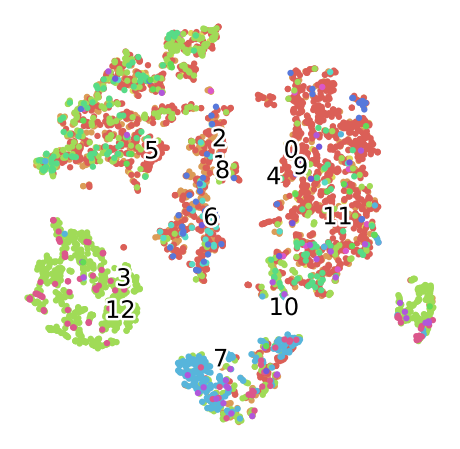

In [26]:
fashion_scatter(tsne, labels)

## Plot TSNE of embedding non-trained

In [27]:
features = []
labels = []
with torch.no_grad():
    for imgs, masks, gt, field_id in tqdm(dl):
        output = net(imgs.cuda(), masks.cuda()).cpu().numpy()
        features.append(output)
        labels.append(gt.numpy())
features = np.concatenate(features)
labels = np.concatenate(labels)

100%|██████████| 279/279 [00:12<00:00, 22.19it/s]


In [28]:
tsne = TSNE(n_components=2, learning_rate='auto',
            init='random').fit_transform(features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(<Figure size 576x576 with 1 Axes>,
 [Text(2.944953, 24.922329, '0'),
  Text(9.289222, 14.138825, '1'),
  Text(5.7697344, 20.91249, '2'),
  Text(0.11022858, -33.467705, '3'),
  Text(-7.8422103, 20.050676, '4'),
  Text(1.7757723, -3.7011538, '5'),
  Text(29.861336, 10.0547905, '6'),
  Text(-42.282425, -46.756855, '7'),
  Text(23.093056, 20.688328, '8'),
  Text(-9.770639, 40.878403, '9'),
  Text(-20.432652, -33.643044, '10'),
  Text(-9.462246, 26.580036, '11'),
  Text(-4.751386, -46.094368, '12')])

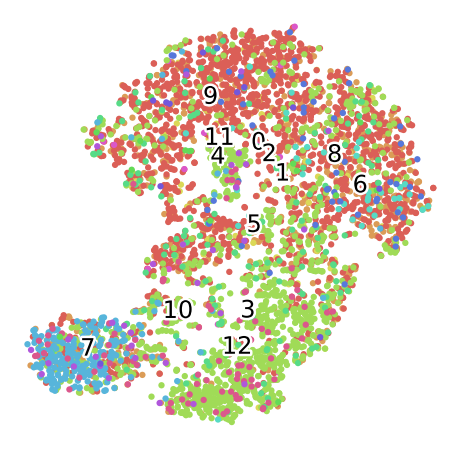

In [29]:
fashion_scatter(tsne, labels)

## Plot TSNE of embeddings pre-trained

In [32]:
net.load_state_dict(torch.load(os.path.join(model_dir, model_name, 'best_model.pth')))
net.eval();

In [33]:
features = []
labels = []
with torch.no_grad():
    for imgs, masks, gt, field_id in tqdm(dl):
        output = net(imgs.cuda(), masks.cuda()).cpu().numpy()
        features.append(output)
        labels.append(gt.numpy())
features = np.concatenate(features)
labels = np.concatenate(labels)

  0%|          | 0/279 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/transformer.py:456: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at  ../aten/src/ATen/native/transformers/attention.cpp:141.)
  src_mask if src_mask is not None else src_key_padding_mask,  # TODO: split into two args
100%|██████████| 279/279 [00:05<00:00, 47.39it/s]


In [34]:
tsne = TSNE(n_components=2, learning_rate='auto',
            init='random').fit_transform(features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(<Figure size 576x576 with 1 Axes>,
 [Text(-8.893345, 3.8252206, '0'),
  Text(0.107440695, 12.7918415, '1'),
  Text(-12.986346, 5.642506, '2'),
  Text(4.1249537, -11.258603, '3'),
  Text(8.987467, 6.929799, '4'),
  Text(8.105522, 29.328913, '5'),
  Text(-12.216348, 32.89925, '6'),
  Text(15.1532955, -20.501728, '7'),
  Text(-7.918045, 15.508734, '8'),
  Text(-13.110351, 10.548532, '9'),
  Text(8.950101, 7.0178366, '10'),
  Text(-4.5683455, 6.0150385, '11'),
  Text(5.6580706, -5.925411, '12')])

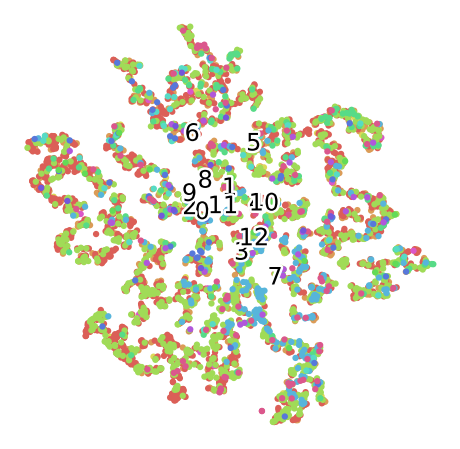

In [35]:
fashion_scatter(tsne, labels)